# 1. Loading Data

In [12]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob

!pip install snorkel
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.analysis import get_label_buckets
from snorkel.preprocess import preprocessor
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds

In [13]:
# # Make sure we're running from the spam/ directory
# if os.path.basename(os.getcwd()) == "snorkel-tutorials":
#     os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

In [14]:
DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

In [3]:
# Download the spaCy english model
! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
#from utils import load_spam_dataset

# df_train, df_test = load_spam_dataset()

# # We pull out the label vectors for ease of use later
# Y_test = df_test.label.values

In [16]:
filenames = sorted(glob.glob("data/Youtube*.csv"))

In [19]:
dfs = []
for i, filename in enumerate(filenames, start=1):
    df = pd.read_csv(filename)
    # Lowercase column names
    df.columns = map(str.lower, df.columns)
    # Remove comment_id field
    df = df.drop("comment_id", axis=1)
    # Add field indicating source video
    df["video"] = [i] * len(df)
    # Rename fields
    df = df.rename(columns={"class": "label", "content": "text"})
    # Shuffle order
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    dfs.append(df)

In [5]:
# df = pd.read_csv('https://raw.githubusercontent.com/Branden-Kang/Snokel/master/Data/Youtube%2001-comments%20Psy.csv')
# # Lowercase column names
# df.columns = map(str.lower, df.columns)
# # Remove comment_id field
# df = df.drop("comment_id", axis=1)
# # Rename fields
# df = df.rename(columns={"class": "label", "content": "text"})
# # Shuffle order
# df = df.sample(frac=1, random_state=123).reset_index(drop=True)

In [22]:
df_train = pd.concat(dfs[:4])

In [26]:
df_dev = df_train.sample(100, random_state=123)

In [7]:
# df_train = df.copy()
# df_dev = df_train.sample(100, random_state=123)

In [27]:
df_valid_test = dfs[4]

In [28]:
df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

In [30]:
# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

In [31]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

In [32]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


# 2. Writing Labeling Functions (LFs)

In [34]:
@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

     |████████████████████████████████| 143kB 4.7MB/s 
     |████████████████████████████████| 10.4MB 15.1MB/s 
     |████████████████████████████████| 1.8MB 46.9MB/s 
     |████████████████████████████████| 6.7MB 21.0MB/s 
     |████████████████████████████████| 3.8MB 42.8MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=a0561d69e7af9d9a05878c6937f6a1700b7e6297e597abfc34c24b1b5cdf5ce8
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: pandas 1.0.5
    

In [35]:
lfs = [check_out, check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

  0%|          | 0/1586 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3848: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  --------
100%|██████████| 1586/1586 [00:00<00:00, 6468.18it/s]


In [36]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1,  1],
       ...,
       [ 1,  1],
       [-1,  1],
       [ 1,  1]])

In [37]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%


In [38]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.214376,0.0


In [39]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,1,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,1,3
89,Stricker Stric,NaN,eminem new song check out my videos,1,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,1,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",1,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,1,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,1,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",1,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",1,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,1,4


In [40]:
buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,1,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,1,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",1,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,1,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,1,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",1,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,1,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,1,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,1,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,0,1


In [41]:
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [42]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

  0%|          | 0/1586 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3848: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  --------
100%|██████████| 1586/1586 [00:00<00:00, 5817.96it/s]


In [43]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [45]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",1,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,1,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",1,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",1,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,1,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,0,1


In [46]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [47]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

In [48]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

  0%|          | 0/1586 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3848: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  --------
100%|██████████| 1586/1586 [00:02<00:00, 635.04it/s]


In [49]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


# 3. Writing More Labeling Functions

In [50]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

In [51]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

In [52]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

In [53]:
@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [54]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

# 4. Combining Labeling Function Outputs with the Label Model

In [55]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

In [56]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

  0%|          | 0/1586 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3848: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  --------
100%|██████████| 250/250 [00:03<00:00, 65.48it/s]


In [57]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.186003,0.110340
keyword_subscribe,1,[1],0.127364,0.107818,0.068096
keyword_http,2,[1],0.119168,0.102144,0.083228
keyword_please,3,[1],0.112232,0.109710,0.057377
keyword_song,4,[0],0.141866,0.111602,0.043506
regex_check_out,5,[1],0.233922,0.133039,0.086381
short_comment,6,[0],0.225725,0.144388,0.074401
has_person_nlp,7,[0],0.082598,0.060530,0.025221
textblob_polarity,8,[0],0.035309,0.032156,0.005044
textblob_subjectivity,9,[0],0.357503,0.261665,0.160151


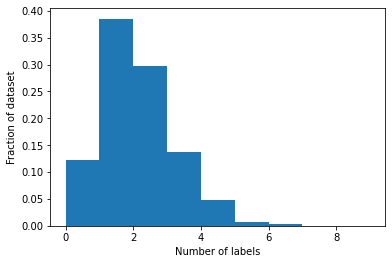

In [58]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [59]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [60]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

In [61]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [62]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   84.0%
Label Model Accuracy:     86.4%


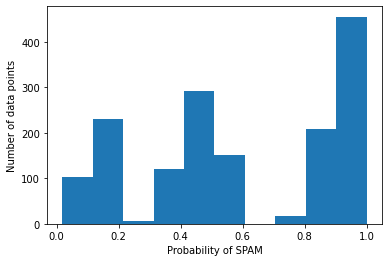

In [63]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

Filtering out unlabeled data points

In [64]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

# 5. Training a Classifier

In [65]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [66]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [67]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 94.0%
